# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Установите количество пропущенных значений поля <code>age</code>:

In [3]:
name_file = "titanic_train.csv"
data = pd.read_csv(name_file)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


In [4]:
len(data[data["age"].isna()])

199

Определите долю выживших

<Axes: xlabel='survived'>

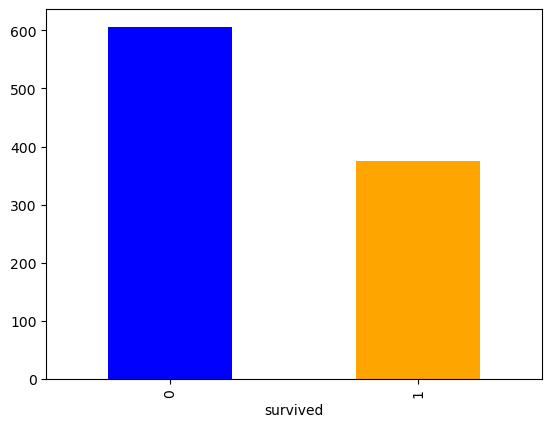

In [5]:
data['survived'].value_counts().plot(kind='bar', color=['blue', 'orange'])

In [6]:
len(data[data["survived"] == 1]) / len(data)

0.382262996941896

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [7]:
missing_values_fraction = data.isna().mean()
missing_values_fraction

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64

In [8]:
columns_to_drop = missing_values_fraction[missing_values_fraction > 1/3].index

In [9]:
dropped_data = data.drop(columns=columns_to_drop)
dropped_data = dropped_data.drop(columns=["ticket"])
dropped_data.head()

,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [10]:
dropped_data["fam_size"] = dropped_data["sibsp"] + dropped_data["parch"]
dropped_data = dropped_data.drop(columns=["sibsp", "parch"])
dropped_data.head()

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0


In [11]:
dropped_data.fam_size.mean()

0.8664627930682977

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [12]:
dropped_data.shape[1] - 1

7

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [13]:
condition = (dropped_data['sex'] == 'female') & (dropped_data['pclass'] == 1)
probability_of_survival = dropped_data[condition]['survived'].mean()
probability_of_survival

0.9711538461538461

Постройте гистограммы выжиших и невыживших по возрастам.

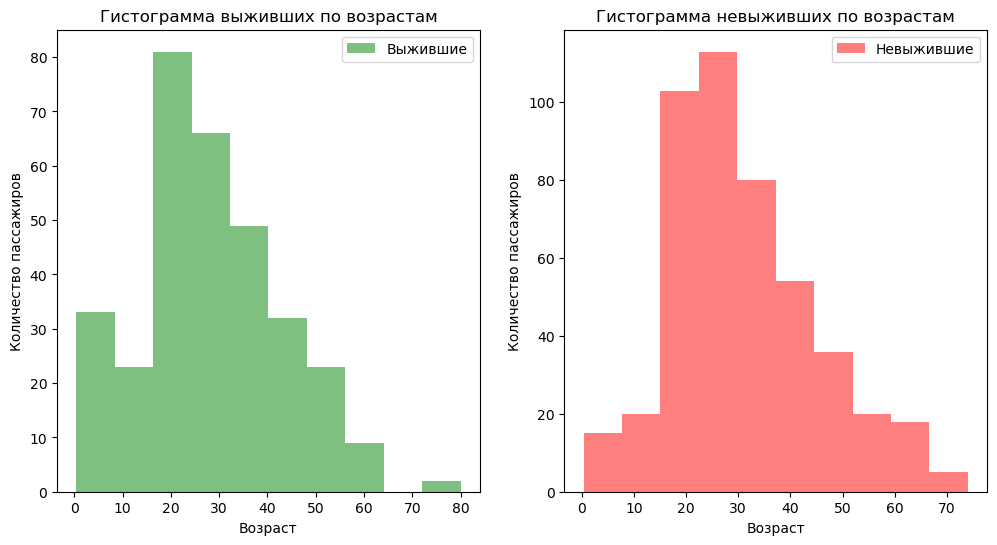

In [14]:
survived = dropped_data[dropped_data['survived'] == 1]
not_survived = dropped_data[dropped_data['survived'] == 0]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].hist(survived['age'], bins=10, alpha=0.5, color='green', label='Выжившие')
axes[0].set_title('Гистограмма выживших по возрастам')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество пассажиров')
axes[0].legend()

axes[1].hist(not_survived['age'], bins=10, alpha=0.5, color='red', label='Невыжившие')
axes[1].set_title('Гистограмма невыживших по возрастам')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('Количество пассажиров')
axes[1].legend()

plt.show()

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [15]:
not_cat_data = dropped_data.drop(columns=["name", "embarked", "sex" ])
not_cat_data_drop_NaN = not_cat_data[~not_cat_data.isna().any(axis=1)]
not_cat_data_drop_NaN.head()

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0


In [16]:
X, y = not_cat_data_drop_NaN.iloc[:, not_cat_data_drop_NaN.columns != "survived"], not_cat_data_drop_NaN["survived"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

In [18]:
regressor = LogisticRegression(random_state=11, max_iter=1000)
model = regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)
f1_score(y_test, y_predict)

0.5471698113207547

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [19]:
not_cat_data = dropped_data.drop(columns=["name", "embarked", "sex" ])
not_cat_and_mean_age_data = not_cat_data.apply(lambda x: x.fillna(x.mean()))

In [20]:
X, y = not_cat_and_mean_age_data.iloc[:, not_cat_and_mean_age_data.columns != "survived"], not_cat_and_mean_age_data["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

In [21]:
regressor = LogisticRegression(random_state=11, max_iter=1000)
model = regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)
f1_score(y_test, y_predict)

0.4297520661157025

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [22]:
not_cat_data_with_name = dropped_data.drop(columns=["embarked", "sex" ])

In [23]:
not_cat_data_with_name["honorific"] = not_cat_data_with_name.name.apply(lambda x: x.split(",")[1].split(".")[0])
not_cat_data_with_name["honorific"].nunique()

14

In [32]:
not_cat_data_with_name.honorific.value_counts()

honorific
 Mr              572
 Miss            194
 Mrs             145
 Master           46
 Rev               6
 Dr                6
 Col               3
 Mlle              2
 Ms                2
 Dona              1
 the Countess      1
 Major             1
 Don               1
 Capt              1
Name: count, dtype: int64

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [33]:
def transform(s):
    s = s.strip()
    if s in ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']:
        return "Mr"
    elif s in ['Dona', 'the Countess']:
        return "Mrs"
    elif s in ['Mlle', 'Ms']:
        return "Miss"
    else:
        return s

In [34]:
not_cat_data_with_name["honorific"] = not_cat_data_with_name.honorific.apply(transform)

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [39]:
len(not_cat_data_with_name[not_cat_data_with_name["honorific"] == "Master"]) / len(dropped_data[dropped_data["sex"] == "male"])

0.07232704402515723

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [38]:
not_cat_data_with_name[not_cat_data_with_name["honorific"] == "Master"]["age"].mean()

5.128205128205129

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [40]:
not_cat_data_with_name['age'] = not_cat_data_with_name.groupby('honorific')['age'].transform(lambda x: x.fillna(x.mean()))
not_cat_data_with_name.head()

,pclass,survived,name,age,fare,fam_size,honorific
0,3,1,"Smyth, Miss. Julia",22.005765,7.7333,0,Miss
1,3,1,"Glynn, Miss. Mary Agatha",22.005765,7.7500,0,Miss
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",38.000000,7.2292,0,Mrs
3,3,0,"Vovk, Mr. Janko",22.000000,7.8958,0,Mr
4,3,0,"de Pelsmaeker, Mr. Alfons",16.000000,9.5000,0,Mr


In [41]:
not_cat_data_with_all_age = not_cat_data_with_name.drop(columns=["honorific", "name"])
X, y = not_cat_data_with_all_age.iloc[:, not_cat_data_with_all_age.columns != "survived"], not_cat_data_with_all_age["survived"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

In [45]:
regressor = LogisticRegression(random_state=11, max_iter=1000)
model = regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)
f1_score(y_test, y_predict)

0.43902439024390244

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [47]:
dropped_data["honorific"] = dropped_data.name.apply(lambda x: x.split(",")[1].split(".")[0])
dropped_data['age'] = dropped_data.groupby('honorific')['age'].transform(lambda x: x.fillna(x.mean()))
dropped_data = dropped_data.drop(columns=["name", "honorific"])
dropped_data.head()

,pclass,survived,sex,age,fare,embarked,fam_size
0,3,1,female,21.941774,7.7333,Q,0
1,3,1,female,21.941774,7.7500,Q,0
2,3,1,female,38.000000,7.2292,C,0
3,3,0,male,22.000000,7.8958,S,0
4,3,0,male,16.000000,9.5000,S,0


In [48]:
data_cat = pd.get_dummies(dropped_data, drop_first=True)

In [49]:
data_cat.head()

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,1,21.941774,7.7333,0,False,True,False
1,3,1,21.941774,7.7500,0,False,True,False
2,3,1,38.000000,7.2292,0,False,False,False
3,3,0,22.000000,7.8958,0,True,False,True
4,3,0,16.000000,9.5000,0,True,False,True


In [50]:
X, y = data_cat.iloc[:, data_cat.columns != "survived"], data_cat["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)